## Prerequisites

Install the W&B Python SDK and log in:

In [ ]:

!pip install --upgrade -q wandb

In [ ]:
wandb.login(key="xxb43dd118f9a14e83xx12c597ad8d06bdfed4xx") ## change this to your wandb id 

In [ ]:
# Log in to your W&B account
import wandb
import random
import math

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24s016 (da24s016-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip

--2025-04-15 20:43:02--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.250.4.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  23.7MB/s    in 2m 40s  

2025-04-15 20:45:43 (22.7 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [ ]:
!unzip nature_12K.zip

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [ ]:
train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

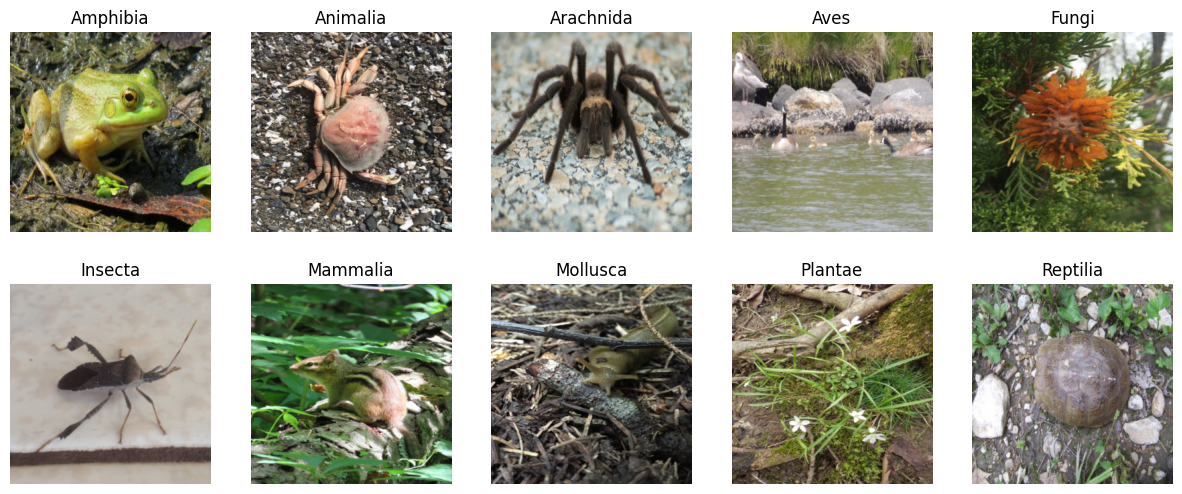

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision.io import read_image
from torchvision.transforms import Resize, ToPILImage
import matplotlib.pyplot as plt
import os

# Initialize figure
fig = plt.figure(figsize=(15, 6))
rows, columns = 2, 5
i = 1

# Loop through categories
for category in categories:
    dir_path = os.path.join(train_dir, category)

    for img_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, img_name)

        # Read image using PyTorch
        img_tensor = read_image(img_path)
        # Resize image using torchvision transforms
        resize_transform = Resize((300, 300))
        resized_img_tensor = resize_transform(img_tensor)

        # Convert tensor to PIL image for visualization
        pil_img = ToPILImage()(resized_img_tensor)

        # Add subplot and display image
        fig.add_subplot(rows, columns, i)
        plt.imshow(pil_img)
        plt.axis('off')
        plt.title(category)

        i += 1
        break  # Show only one image per category

plt.show()


In [ ]:
import numpy as np
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define directories
train_dir = 'inaturalist_12K/train/'
test_dir = 'inaturalist_12K/val/'

# Define transformations with additional augmentations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomRotation(15),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(test_dir, data_transforms['val'])
}

# Split validation dataset into two equal halves
val_dataset = image_datasets['val']
val_size = len(val_dataset)
half_size = val_size // 2  # Integer division to split evenly
# If val_size is odd, one half will have one more sample
val_half1, val_half2 = random_split(val_dataset, [half_size, val_size - half_size])

# Create dataloaders for train, val_half1, and val_half2
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True, num_workers=2, pin_memory=True),
    'val': DataLoader(val_half1, batch_size=64, shuffle=False, num_workers=2),
    'test': DataLoader(val_half2, batch_size=64, shuffle=False, num_workers=2)
}

# Get dataset sizes and class names
dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(val_half1),
    'test': len(val_half2)
}
class_names = image_datasets['train'].classes

# Set device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print summary information
print(f"Training dataset size: {dataset_sizes['train']}")
print(f"Validation half 1 size: {dataset_sizes['val']}")
print(f"Validation half 2 size: {dataset_sizes['test']}")
print(f"Class names: {class_names}")
print(f"Using device: {device}")

Training dataset size: 9999
Validation half 1 size: 1000
Validation half 2 size: 1000
Class names: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Using device: cuda:0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlexibleCNN(nn.Module):
    def __init__(self,
                 input_channels=3,
                 num_classes=10,
                 num_conv_layers=5,
                 conv_filters=32,
                 filter_size=3,
                 activation_func=nn.ReLU,
                 dense_neurons=512,
                 dropout_rate=0.25):

        super().__init__()

        self.conv_blocks = nn.ModuleList()
        in_channels = input_channels

        # Adding convolution-activation-batchnorm-maxpool blocks
        for _ in range(num_conv_layers):
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=conv_filters,
                          kernel_size=filter_size, stride=1, padding=filter_size//2),
                nn.BatchNorm2d(conv_filters),  # Adding Batch Normalization
                activation_func(),
                nn.MaxPool2d(kernel_size=2)
                # nn.Dropout2d(0.4)
            ))
            in_channels = conv_filters

        # Flatten layer
        self.flatten = nn.Flatten()

        # Calculating input size for the first fully connected layer
        input_size = conv_filters * (224 // (2**num_conv_layers))**2  # Calculate input size dynamically

        # Fully connected layers with Dropout
        self.fc1 = nn.Linear(input_size, dense_neurons)  # Use calculated input size
        self.dropout = nn.Dropout(dropout_rate)  # Adding Dropout layer
        self.fc2 = nn.Linear(dense_neurons, num_classes)

    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout during training
        x = self.fc2(x)
        return x

# Example instantiation
model = FlexibleCNN(input_channels=3, num_classes=10, num_conv_layers=5,
                    conv_filters=48, filter_size=5, activation_func=nn.ReLU,
                    dense_neurons=512)

print(model)


FlexibleCNN(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1-4): 4 x Sequential(
      (0): Conv2d(48, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2352, out_features=512, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
import wandb
wandb.init(project="test_project")
wandb.log({"test": 1})
wandb.finish()

In [ ]:

import wandb
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import random

random.seed(42)



sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-4]
        },

        'num_epochs': {
            'values': [2]
        },
        'freeze_layers': {
            'values': [5, 10, 15]
        }
    }
}

def train():
    # Default configuration
    config_defaults = {
        'learning_rate': 1e-4,
        'batch_size': 64,
        'num_epochs': 5,
        'freeze_layers': 10,
        'num_classes': 10
    }

    # Initialize wandb
    wandb.init(config=config_defaults)
    config = wandb.config

    # Set run name
    wandb.run.name = f'resnet50_lr__fz_{config.batch_size}'

    # Load pre-trained ResNet50
    # model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    model = models.resnet50(pretrained=True)

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Replace final layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, config.num_classes)

    # Make final layer trainable
    for param in model.fc.parameters():
        param.requires_grad = True

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=config.learning_rate)

    # Training loop
    best_val_acc = 0.0

    for epoch in range(config.num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Log metrics to wandb
            wandb.log({
                f'{phase}_loss': epoch_loss,
                f'{phase}_accuracy': epoch_acc,
                'epoch': epoch
            })

            if phase == 'val' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc

        print(f'Epoch {epoch + 1}/{config.num_epochs}')
        print(f'{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')

    # Fine-tuning phase
    # Unfreeze layers based on config
    total_layers = sum(1 for _ in model.parameters())
    freeze_point = total_layers - config.freeze_layers
    layer_count = 0

    for param in model.parameters():
        if layer_count < freeze_point:
            param.requires_grad = False
        else:
            param.requires_grad = True
        layer_count += 1

    # Update optimizer for fine-tuning
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                         lr=config.learning_rate/10)

    # Fine-tuning loop (additional epochs)
    for epoch in range(3):  # Additional 3 epochs for fine-tuning
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Log fine-tuning metrics
            wandb.log({
                f'finetune_{phase}_loss': epoch_loss,
                f'finetune_{phase}_accuracy': epoch_acc,
                'finetune_epoch': epoch
            })

    return model

# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="resnet50-pytorch-tuning")

# Run the sweep
wandb.agent(sweep_id, train, count=10)
wandb.finish()

Create sweep with ID: im2xbayo
Sweep URL: https://wandb.ai/da24s016-indian-institute-of-technology-madras/resnet50-pytorch-tuning/sweeps/im2xbayo


wandb: Agent Starting Run: 74jiextw with config:
wandb: 	freeze_layers: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


Epoch 1/2
val Loss: 1.4943 | Acc: 0.6720
Epoch 2/2
val Loss: 1.1367 | Acc: 0.7300


wandb: Agent Starting Run: vq1aup8s with config:
wandb: 	freeze_layers: 15
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 2


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/2
val Loss: 1.5041 | Acc: 0.6920
Epoch 2/2
val Loss: 1.1564 | Acc: 0.7250


wandb: Agent Starting Run: 9tkuscx7 with config:
wandb: 	freeze_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 2


Epoch 1/2
val Loss: 1.4924 | Acc: 0.6710
Epoch 2/2
val Loss: 1.1366 | Acc: 0.7230


wandb: Agent Starting Run: lq85z3r0 with config:
wandb: 	freeze_layers: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 2


Epoch 1/2
val Loss: 1.5181 | Acc: 0.6830
Epoch 2/2
val Loss: 1.1558 | Acc: 0.7250


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4iq2arco with config:
wandb: 	freeze_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_epochs: 2


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim

# Hyperparameters
num_epochs = 5  # Number of epochs to train
learning_rate = 1e-4  # Learning rate (0.001 as specified)

# Load pre-trained ResNet50
model = models.resnet50(weights=True)
# model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# Ensure the new layer is trainable
for param in model.fc.parameters():
    param.requires_grad = True

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)  # Optimize only the final layer

# Move model to the appropriate device (assuming device is defined, e.g., 'cuda' or 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop with test evaluation
lossi = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Training and validation phases
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    lossi.append(loss.item())

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        print(f'{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')

        # Track best validation accuracy
        if phase == 'val' and epoch_acc > best_val_acc:
            best_val_acc = epoch_acc




Epoch 1/5
----------
train Loss: 1.9343 | Acc: 0.4432
val Loss: 1.4852 | Acc: 0.6930
Epoch 2/5
----------
train Loss: 1.4595 | Acc: 0.6269
val Loss: 1.1557 | Acc: 0.7300
Epoch 3/5
----------
train Loss: 1.2485 | Acc: 0.6537
val Loss: 0.9766 | Acc: 0.7530
Epoch 4/5
----------
train Loss: 1.1479 | Acc: 0.6693
val Loss: 0.8856 | Acc: 0.7670
Epoch 5/5
----------
train Loss: 1.0671 | Acc: 0.6772
val Loss: 0.8367 | Acc: 0.7750


In [ ]:
running_loss = 0.0
running_corrects = 0

for inputs, labels in dataloaders["test"]:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / dataset_sizes[phase]
epoch_acc = running_corrects.double() / dataset_sizes[phase]
print(f'Test Loss: {epoch_loss:.4f} | Test Acc: {epoch_acc:.4f}')

Test Loss: 0.8567 | Test Acc: 0.7630


Attempting to collect 30 samples for the grid...
Processing batch 1/16...
Collected 30 samples.
Plotting results...


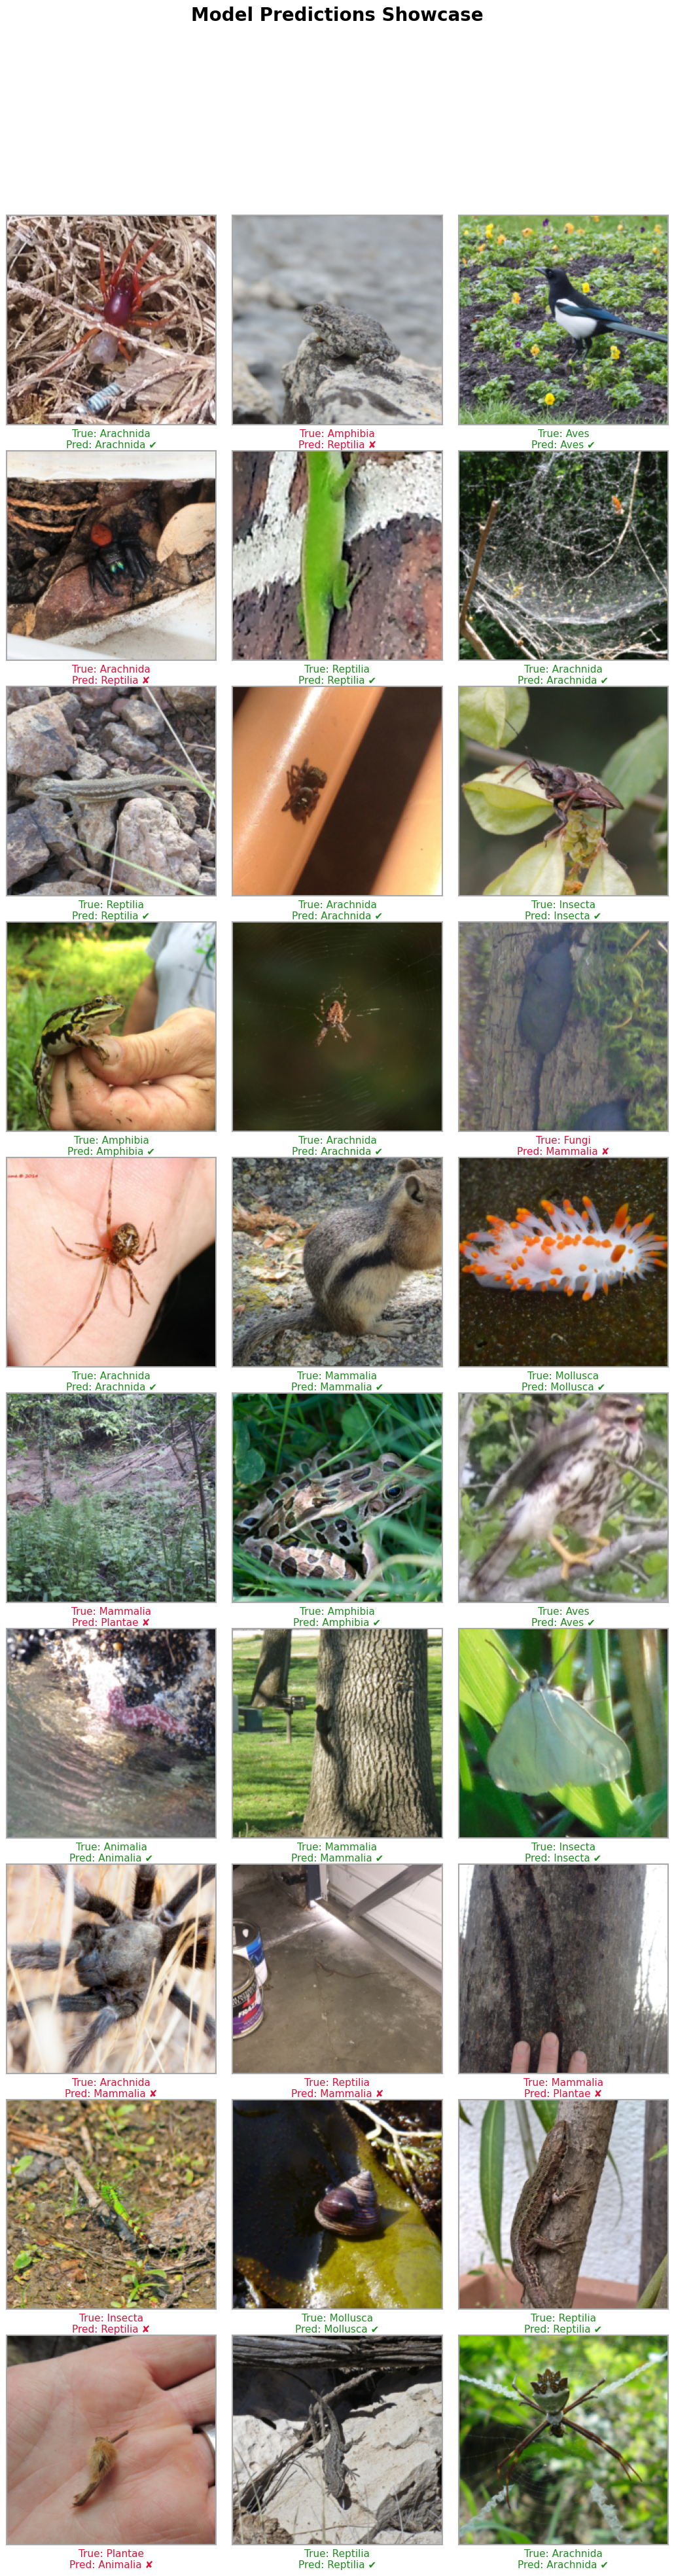

Plotting complete.


In [ ]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

test_loader = dataloaders["test"]
model.eval()  # Set model to evaluation mode

# --- Configuration for the Grid ---
rows = 10
cols = 3
num_samples_to_show = rows * cols
print(f"Attempting to collect {num_samples_to_show} samples for the grid...")

# --- Collect Samples ---
collected_images = []
collected_true_labels = []
collected_preds = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        print(f"Processing batch {batch_idx + 1}/{len(test_loader)}...")
        images_device, labels_device = images.to(device), labels.to(device)
        outputs = model(images_device)
        _, preds_device = torch.max(outputs, 1)

        # Move needed data back to CPU for storage
        images_cpu = images.cpu()
        labels_cpu = labels.cpu()
        preds_cpu = preds_device.cpu()

        # Add samples from this batch to our lists
        for i in range(len(labels_cpu)):
            if len(collected_images) < num_samples_to_show:
                collected_images.append(images_cpu[i])
                collected_true_labels.append(labels_cpu[i].item())
                collected_preds.append(preds_cpu[i].item())
            else:
                break # Stop collecting within the batch

        # Stop iterating through batches if we have enough samples
        if len(collected_images) >= num_samples_to_show:
            print(f"Collected {len(collected_images)} samples.")
            break # Stop collecting from loader
    else:
        # This runs if the loop finished without breaking (i.e., loader exhausted)
        print(f"Warning: Test loader exhausted. Collected only {len(collected_images)} samples (requested {num_samples_to_show}).")


# --- Plotting the Grid ---
print("Plotting results...")

# Check if any samples were collected
if not collected_images:
    print("No samples collected, cannot plot.")
else:
    # Create figure and axes grid
    # Adjust figsize - especially height to accommodate text below
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 4.0)) # Increased height slightly

    # Flatten the axes array for easy iteration, handle case of single row/col
    if rows * cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i in range(len(collected_images)):
        ax = axes[i]
        image_tensor = collected_images[i]
        true_idx = collected_true_labels[i]
        pred_idx = collected_preds[i]

        # Prepare image for display (Tensor (C,H,W) -> Numpy (H,W,C))
        img_display = image_tensor.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1) # Ensure valid range [0,1]

        # Display the image
        ax.imshow(img_display)

        # --- Remove ticks, keep border ---
        ax.set_xticks([])
        ax.set_yticks([])
        border_color = 'darkgrey'
        border_width = 1.5
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(border_width)
            spine.set_visible(True)

        # --- Text Labels BELOW Image ---
        is_correct = (pred_idx == true_idx)
        true_label_str = class_names[true_idx]
        pred_label_str = class_names[pred_idx]
        symbol = "✔" if is_correct else "✘"
        color = 'forestgreen' if is_correct else 'crimson' # Slightly different colors

        # Increased font size for labels
        font_size_labels = 11 # Increased font size

        # Combine labels into a single string with a newline
        label_text = f"True: {true_label_str}\nPred: {pred_label_str} {symbol}"

        # Use ax.set_xlabel to place text below the axes area
        ax.set_xlabel(label_text,
                      color=color,
                      fontsize=font_size_labels,
                      fontweight='normal', # Can set to 'bold' if preferred
                      labelpad=4) # Adjust vertical padding below the image/border

    # Turn off axes for any remaining subplots if fewer samples were collected
    for j in range(len(collected_images), len(axes)):
        axes[j].axis('off')

    # Adjust layout - Fine-tune padding
    plt.tight_layout(pad=1.0, h_pad=2.0, w_pad=1.0) # Adjusted padding

    # Main Title - Larger and Bolder
    main_title_fontsize = 20
    fig.suptitle("Model Predictions Showcase", fontsize=main_title_fontsize, y=1.02, fontweight='bold') # Adjusted y

    # Adjust top/bottom margin if needed
    plt.subplots_adjust(top=0.94, bottom=0.05) # Make space for title and xlabels

    plt.show()
    print("Plotting complete.")

